# Tweaking Seaborn

## Introduction
I recently had a very interesting exercise in tailoring Seaborn graphic output.

The background is that I had access to a database of water quality measures at more than 100 sites.  At each site, once a month, a volunteer (or volunteers) measured six physical parameters (temperature, salinity, dissolved oxygen etc).
I was requested to develop graphics to show the volunteers a summary of the measurements  collected at their sites.

This post describes the process to arrive at the final graphic, satisfying the database owner and volunteer coordinator.  I will give some demonstration code at stages (using demonstration data) to show how I bent Seaborn to my will :)  .

## Implementation

### Imports

In [10]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# used for environment documentation
import sys
import os
import platform
import datetime

### Supporting libraries

In [11]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [12]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Data cleaning

A non-trivial amount of data cleaning was required (as might be expected in a field process that involved recording physical measurements on a paper form, entering into Excel, and then transferring into an Access database). Eventually we had a clean Pandas dataframe to start producing graphics.

I elected to use Seaborn as the main graphics production tool.

### Illustrative dataset

To demonstrate some of the issues I encountered, a toy dataset is constructed below.  For one site only, it has one physical variable, with measurements taken every month (mostly).  There is one outlier point.

In [13]:
date_range = pd.date_range(
    start='1/1/2015', periods=80, freq='M'
)

data_d = {
    'site_code': 'STU100',
    'datesampletaken': date_range,
    'turbidity_ntu': np.random.normal(
        loc=20, scale=5, size=len(date_range)
    ),
}
df_clean = pd.DataFrame(data_d)

# inject an early start date
df_clean.loc[0, 'datesampletaken'] = pd.to_datetime(
    '2014/1/1'
)

# inject an outlier physical value
df_clean.loc[40, 'turbidity_ntu'] = 150

# inject a gap in measurements
df_clean.loc[46:, 'datesampletaken'] = pd.date_range(
    start='1/8/2020', periods=34, freq='M'
)

In [14]:
df_clean.head(2)

,site_code,datesampletaken,turbidity_ntu
0,STU100,2014-01-01,27.792293
1,STU100,2015-02-28,16.805165


## Graphics production steps

### Initial graphic

My first initial attempt at portraying the data was as below.  I use the Seaborn ```lineplot```, in a long narrow chart that will be stacked on graphs of the other physical parameters.  I though it important to actually show where the data points were, as well as connecting them.

Text(0.5, 0.98, 'Site Code: STU100')

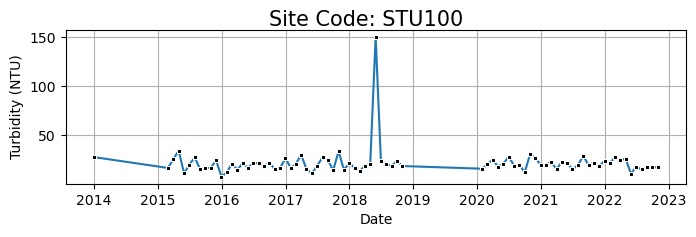

In [15]:
#  generate a long narrow strip chart
fig, ax = plt.subplots(figsize=(8, 2))

# the physical value we are plotting
val = 'turbidity_ntu'

sns.lineplot(
    x='datesampletaken',
    y=val,
    data=df_clean,
    ax=ax,
    marker='s',
    markersize=3,
    markerfacecolor='black',
)

# set x,y grid
ax.grid(axis='both')

# set axis labels
ax.set_xlabel('Date')

ylabel = 'Turbidity (NTU)'
ax.set_ylabel(ylabel)

# add an overall figure title
fig.suptitle(
    'Site Code: ' + df_clean.loc[0, 'site_code'],
    fontsize=15,
    ha='center',
    va='top',
)

### Gaps in time-series

#### Initial gap

One of the issues my 'customer' had with the default dataframe-to-graphic process, was that for some sites there were big gaps in the collection of the data.  This could be for a variety of reason (volunteers away on holiday, with no backup, access restrictions), including - during Australia droughts - no water to measure.  

Furthermore, I think that initially an initial prototype data-collection effort was performed, as for almost all sites, there was a big gap between the first and subsequent data collection dates.

Because the main purpose of the graphics was to allow comparison of the month-to-month values, it was decided to drop the first month of every site.

In [16]:
# get just this active site rows, and drop the earliest row, and reindex
site_code = 'STU100'

df_site = (
    df_clean.query('site_code==@site_code')
    .sort_values(by='datesampletaken')
    .iloc[1:, :]
    .copy()
    .reset_index(drop=True)
)

So now we get:


Text(0.5, 0.98, 'Site Code: STU100')

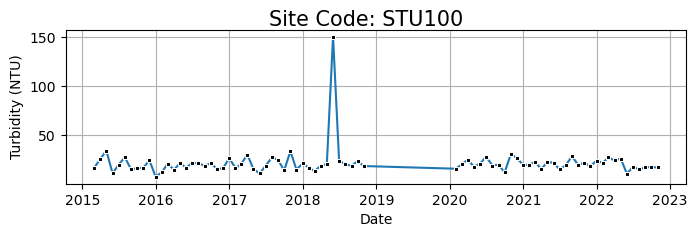

In [17]:
#  generate a long narrow strip chart
fig, ax = plt.subplots(figsize=(8, 2))

# the physical value we are plotting
val = 'turbidity_ntu'

sns.lineplot(
    x='datesampletaken',
    y=val,
    data=df_site,
    ax=ax,
    marker='s',
    markersize=3,
    markerfacecolor='black',
)

# set x,y grid
ax.grid(axis='both')

# set axis labels
ax.set_xlabel('Date')

ylabel = 'Turbidity (NTU)'
ax.set_ylabel(ylabel)

# add an overall figure title
fig.suptitle(
    'Site Code: ' + df_clean.loc[0, 'site_code'],
    fontsize=15,
    ha='center',
    va='top',
)

#### Gaps in the middle

I trashed around for a while, trying to find a way to tell Seaborn __not__ to draw a line between two points in a line plot.  Finally (via Stack Overflow), I found the trick was to tell Seaborn to draw a line joining a subset of the points.  Two (or more) subsets do __not__ have a line joining them.  I do this by creating a new column in the dataframe ('group'); the ```hue='group'``` clause in the Seaborn call tells Seaborn to plot each group of points with a different line color, except we subvert this by defining a palette with as many repetitions of ```blue``` as there are groups of datapoints not widely separated in time. 

Time for a supporting function.  I fudged a bit, that the loose verbal specification was "more than half a year": I defined that to mean greater than  180 days.

In [18]:
def group_by_period(df: pd.DataFrame):
    '''
    group_by_period: assign a group integer to each row, which increments across big time gaps
    '''
    group_no = 1
    df['group'] = group_no

    MAX_DAYS_GAP = 180  # ~ 6 months

    for i in range(1, len(df)):

        if (
            df.loc[i, 'datesampletaken']
            - df.loc[i - 1, 'datesampletaken']
        ) > pd.Timedelta(value=MAX_DAYS_GAP, unit='D'):
            # have big gap in sample taken dates, so assign to a new group
            group_no = group_no + 1
            df.loc[i:, 'group'] = group_no
        # end if
    # end for

    return None


# end group_by_period

Example with lines joining datapoints with a big gap supressed.

<AxesSubplot:xlabel='datesampletaken', ylabel='turbidity_ntu'>

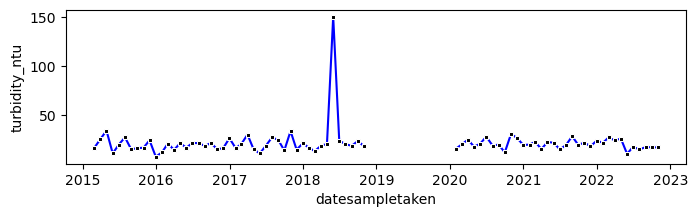

In [19]:
# find  big gaps (>6 months) in plot
group_by_period(df_site)

#  generate a long narrow strip chart
fig, ax = plt.subplots(figsize=(8, 2))


# plot the data reading by time as a line
# we have grouped the rows into segments with no big time gaps
# but we plot each segment the same color (blue)
# - see palette parameter in lineplot call
sns.lineplot(
    x='datesampletaken',
    y=val,
    data=df_site,
    ax=ax,
    marker='s',
    markersize=3,
    markerfacecolor='black',
    hue='group',
    legend=False,
    palette=['blue'] * df_site['group'].max(),
)

### Outliers 

I had a little bit of back-and-forth on the issue of how to treat outliers.  I had a deaply ingrained reluctance to removing them from the graphics. Pondering the issue now, I understand that this situation is not a standard Quality Control graph, where a single outlier can be a sign that a machine tool has been jolted out of alignment, and needs to inspected immediately.

Further, none of the physical quantities being  measured have any short-term human safety or health implications.  If we were measuring _E. Coli_, then we would probably urgently move heaven and earth to find the cause of a spike in _E. Coli_ readings.  In this case, the primary purpose of the measurements is to detect long term trends.

In the end, we adopted the approach that any readings more than five standard deviations away from the median would be supressed  (the standard deviations are computed using all the data).  

The graphs are there to tell a story on long term trends to possibly non-technical volunteers, and showing the outliers would distract from that story. As part of the process of generating graphics for distribution, a report on outliers was also generated, for any more technically oriented people interested.

The code below sets what were outlier values (as defined above) to _NaN_, so that Seaborn doesn't draw them.

In [20]:
# filter out exterme values from plot
# val is set to column name of physical quantity currently being processed
EXTREME = 5
avg = df_site[val].median()
std = df_site[val].std()

for i, v in enumerate(df_site[val]):
    delta = np.abs(v - avg) / std
    if delta > EXTREME:
        # set the extreme value to a NaN, so it wont be added to line plot
        df_site.loc[i, val] = np.nan
    # end if
# end for

#### Final result

We plot the data (outliers removed), and also add the median line, and the lines one standard deviation above and below to median.  Because we have added extra lines, we need a legend to explain these.

Text(0.5, 0, 'Date')

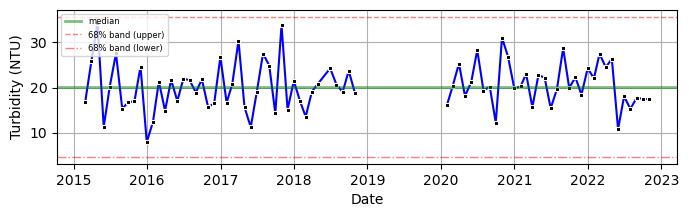

In [21]:
#  generate a long narrow strip chart
fig, ax = plt.subplots(figsize=(8, 2))

# plot the data reading by time as a line
# we have grouped the rows into segments with no big time gaps
# but we plot each segment the same color (blue)
# - see palette parameter in lineplot call
sns.lineplot(
    x='datesampletaken',
    y=val,
    data=df_site,
    ax=ax,
    marker='s',
    markersize=3,
    markerfacecolor='black',
    hue='group',
    legend=False,
    palette=['blue'] * df_site['group'].max(),
)

# get x,y gris
ax.grid(axis='both')

# add the mean line, and +/- 1 std lines
ax.axhline(
    y=avg,
    color='green',
    linestyle='-',
    linewidth=2,
    alpha=0.5,
    label='median',
)
ax.axhline(
    y=avg + std,
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5,
    label='68% band (upper)',
)
ax.axhline(
    y=avg - std,
    color='red',
    linestyle='-.',
    linewidth=1,
    alpha=0.5,
    label='68% band (lower)',
)

# create legend (small)
ax.legend(loc='upper left', fontsize=6)

# set axis labels
ax.set_ylabel(ylabel)
ax.set_xlabel('Date')

### Obligatory cartoon

__[This cartoon](https://www.smbc-comics.com/comic/take-it-off)__ has a humorous take on treatment of outliers.

-----------------
## Reproducability 

This section contains information to support reproducing this notebook.

In [22]:
theNotebook = 'SeabornTweaking.ipynb'

print('current wkg dir: ' + os.getcwd())
print('Notebook name: ' + theNotebook)
print(
    'Notebook run at: '
    + str(datetime.datetime.now())
    + ' local time'
)
print(
    'Notebook run at: '
    + str(datetime.datetime.utcnow())
    + ' UTC'
)
print('Notebook run on: ' + platform.platform())

current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\PythonNotebookProject\develop
Notebook name: SeabornTweaking.ipynb
Notebook run at: 2023-05-22 21:04:56.389783 local time
Notebook run at: 2023-05-22 11:04:56.389783 UTC
Notebook run on: Windows-10-10.0.19045-SP0


In [23]:
%watermark

Last updated: 2023-05-22T21:04:56.421784+10:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [24]:
%watermark -co

conda environment: D:\Anaconda2022



In [25]:
%watermark -iv

seaborn   : 0.11.2
matplotlib: 3.5.2
pandas    : 1.4.4
numpy     : 1.21.5
sys       : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
platform  : 1.0.8

